In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
import datetime
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sys
# sys.path.append(r"source/model_source")
from model.PNet import LSTM, NN, PSiameseNetwork, DatasetUtil, ContrastiveLoss 

In [5]:
n_days_lookahead = int(input('Please input the length of days lookahead in {5, 7, 15, 30, 45, 60, 90, 120}: '))

if(n_days_lookahead not in [5, 7, 15, 30, 45, 60, 90, 120]):
    print('Input does not meet requirements.')
    exit()

data_type = str(input('Please specify the coverage of the data {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2}: '))

if(data_type not in ['A', 'B', 'C']):
    print('Input does not meet requirements.')
    exit()

dit_str = {'A':'mc1', 'B':'mc2', 'C':'mc1_mc2'}

model_type = str(input('Please input the type of trained model to use {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2}: '))

if(model_type not in ['A', 'B', 'C']):
    print('Input does not meet requirements.')
    exit()

def loadData():

    X = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/smart_test.npy',allow_pickle=True)
    y = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/test_labels.npy',allow_pickle=True)
    aging = np.load('../data/aging.npy', allow_pickle = True)

    X = X.astype('float32')
    y = y.astype('float32')
    aging = aging.astype('float32')

    return X, y, aging


def get_all_metrics(true, predicted, score):
    confusion_matrix = metrics.confusion_matrix(true, predicted)
    fpr_list, tpr_list, thersholds = roc_curve(true, score)
    roc_auc = auc(fpr_list, tpr_list)
    TP = confusion_matrix[0][0]
    FN = confusion_matrix[0][1]
    FP = confusion_matrix[1][0]
    TN =  confusion_matrix[1][1]
    precision_of_failed = TP / (TP + FP)
    precision_of_healthy = TN / (TN + FN)
    tpr = TP / (TP + FN)
    fpr = FP / (TN + FP)
    auc_score = roc_auc
    f1_score = 2*precision_of_failed*tpr / (precision_of_failed+tpr)
    print('precision of failed: ', precision_of_failed)
    print('precision of healthy: ', precision_of_healthy)
    print('tpr: ', tpr)
    print('fpr: ', fpr)
    print('auc: ', auc_score)
    print('f1-score: ', f1_score)
    print('roc curve: ')
    plt.plot(fpr_list, tpr_list)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def decision(x_smart, aging, model):
    # ret val: 0(unhealthy) 1(healthy)    
    with torch.no_grad():
        out1, out2 = model(x_smart, aging)
#         print(out1, out2)
        # print(F.pairwise_distance(out1, out2, p=2))
#         print(out1.shape, out2.shape)
        distance = F.pairwise_distance(out1, out2, p=2)
#         print(distance.shape)
#         distance = [F.pairwise_distance(x1, x2, p=2) for (x1,x2) in zip(out1, out2)]
    return distance

def computeScore(distance, limit):
    if distance>1:
        return 0.01
    elif distance<limit:
        return float(1-distance/limit*0.5)
    else: 
        # distance>=limit
        return float(1-(0.5+(distance-limit)/(1-limit)*0.5))
    
def rf_online_predictX(model, X):
    headers = [str(i) for i in range(len(X[0]))]
    dict_X = [dict(zip(headers, x)) for x in X]
    y_pred = []
    for xi in dict_X:
        yi_pred = model.predict_one(xi)
        y_pred.append(yi_pred)
    return np.asarray(y_pred)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_size_smart = 330
hidden_size_smart = 128
output_size_smart = 48
input_size_aging = 5
hidden_size_aging = 32
output_size_aging = 48
output_size_model = 64
num_layers_smart = 3
num_layers_aging = 3
pnet = PSiameseNetwork(
    input_size_smart=input_size_smart, 
    input_size_aging=input_size_aging, 
    hidden_size_smart=hidden_size_smart, 
    hidden_size_aging=hidden_size_aging,
    num_layers_smart=num_layers_smart, 
    num_layers_aging=num_layers_aging,
    output_size_smart=output_size_smart, 
    output_size_aging=output_size_aging,
    output_size_model=output_size_model
)
pnet.load_state_dict(torch.load('../trained_model/' + dit_str[model_type] + '/' + str(n_days_lookahead) + '_days_lookahead/pnet_online.pth'))
rf = joblib.load('../trained_model/' + dit_str[model_type] + '/' + str(n_days_lookahead) + '_days_lookahead/rf_online.pkl')
X_smart_test, y_smart_test, aging = loadData()
print(X_smart_test.shape)

test_dataset_smart = DatasetUtil(X_smart_test, aging, y_smart_test)
test_loader_smart = DataLoader(dataset=test_dataset_smart, batch_size=128, shuffle=False)

cuda
(12000, 30, 11)


------------------ APSNet--------------


/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:144: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore

precision of failed:  0.8370852092713024
precision of healthy:  0.8367482925204065
tpr:  0.8366666666666667
fpr:  0.16283333333333333
auc:  0.9069705972222224
f1-score:  0.8368758856380762
roc curve: 


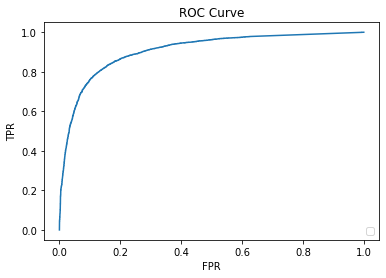

In [7]:
print('------------------ APSNet--------------')

if n_days_lookahead == 5:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.75,  7:0.7,   15:0.8,   30:0.85,  45:0.75,  60:0.6,  90:1.1,120:1}
            best_lower_limit_dit = {5:0.5, 7:0.4,    15:0.3,   30:0.35, 45:0.25, 60:0.23, 90:0.1,  120:0.1}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,  7:0.7,   15:0.8,   30:0.85,  45:0.75,  60:0.6,  90:1.1,120:1}
            best_lower_limit_dit = {5:0.4, 7:0.4,    15:0.3,   30:0.35, 45:0.25, 60:0.23, 90:0.1,  120:0.1}
elif n_days_lookahead == 7:
    if dit_str[model_type] == 'mc1':
        best_upper_limit_dit = {5: 0.98, 7: 1,   15: 1,   30: 0.8,  45: 0.8,  60: 0.8,  90: 0.90, 120: 0.90}
        best_lower_limit_dit = {5: 0.2, 7: 0.25, 15: 0.23, 30: 0.35, 45: 0.24, 60: 0.25, 90: 0.20, 120: 0.3}
    elif dit_str[model_type] == 'mc2':
        best_upper_limit_dit = {5: 2,    7: 1,   15: 1,   30: 1,  45: 1,  60: 1,  90: 5, 120: 5}
        best_lower_limit_dit = {5: 0.25, 7: 0.15, 15: 0.2, 30: 0.1, 45: 0.1, 60: 0.1, 90: 0.1, 120: 0.1}
    elif dit_str[model_type] == 'mc1_mc2':
        if dit_str[data_type] == 'mc1':
            best_upper_limit_dit = {5: 0.8,  7: 0.9,   15: 0.8,   30: 0.85,  45: 0.75,  60: 0.6,  90: 1.1, 120: 1}
            best_lower_limit_dit = {5: 0.5,  7: 0.3,    15: 0.3,   30: 0.35, 45: 0.25, 60: 0.23, 90: 0.1,  120: 0.1}
        elif dit_str[data_type] == 'mc2':
            best_upper_limit_dit = {5: 0.9,  7: 0.7,   15: 0.8,   30: 0.85,  45: 0.75,  60: 0.6,  90: 1.1, 120: 1}
            best_lower_limit_dit = {5: 0.4, 7: 0.4,    15: 0.3,   30: 0.35, 45: 0.25, 60: 0.23, 90: 0.1,  120: 0.1}
elif n_days_lookahead == 15:
    if dit_str[model_type] == 'mc1':
        best_upper_limit_dit = {5: 0.98, 7: 1,   15: 1,   30: 0.8,  45: 0.8,  60: 0.8,  90: 0.90, 120: 0.90}
        best_lower_limit_dit = {5: 0.2, 7: 0.25, 15: 0.23, 30: 0.35, 45: 0.24, 60: 0.25, 90: 0.20, 120: 0.3}
    elif dit_str[model_type] == 'mc2':
        best_upper_limit_dit = {5: 2,    7: 1,   15: 1,   30: 1,  45: 1,  60: 1,  90: 5, 120: 5}
        best_lower_limit_dit = {5: 0.25, 7: 0.15, 15: 0.2, 30: 0.1, 45: 0.1, 60: 0.1, 90: 0.1, 120: 0.1}
    elif dit_str[model_type] == 'mc1_mc2':
        if dit_str[data_type] == 'mc1':
            best_upper_limit_dit = {5: 0.8,  7: 0.7,   15: 0.8,   30: 0.85,  45: 0.75,  60: 0.6,  90: 1.1, 120: 1}
            best_lower_limit_dit = {5: 0.5, 7: 0.4,    15: 0.45,   30: 0.35, 45: 0.25, 60: 0.23, 90: 0.1,  120: 0.1}
        elif dit_str[data_type] == 'mc2':
            best_upper_limit_dit = {5: 0.9,  7: 0.7,   15: 0.8,   30: 0.85,  45: 0.75,  60: 0.6,  90: 1.1, 120: 1}
            best_lower_limit_dit = {5: 0.4, 7: 0.4,    15: 0.3,   30: 0.35, 45: 0.25, 60: 0.23, 90: 0.1,  120: 0.1}
elif n_days_lookahead == 30:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.8,7:0.7,15:0.9,   30:0.7,45:0.75,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.5, 7:0.4,15:0.2,  30:0.35,45:0.25,60:0.23,90:0.1,120:0.1}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,  7:0.7,   15:0.8,   30:0.85,  45:0.75,  60:0.6,  90:1.1,120:1}
            best_lower_limit_dit = {5:0.4, 7:0.4,    15:0.3,   30:0.35, 45:0.25, 60:0.23, 90:0.1,  120:0.1}
elif n_days_lookahead == 45:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.8,7:0.7,15:0.8,30:0.85, 45:0.85,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.5,7:0.4,15:0.3,30:0.35, 45:0.34,60:0.23,90:0.1,120:0.1}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,7:0.7,15:0.8,30:0.85,  45:0.8,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.4,7:0.4,15:0.3,30:0.35,  45:0.3,60:0.23,0:0.1,120:0.1}
elif n_days_lookahead == 60:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.8,7:0.7,15:0.8,30:0.85,45:0.75,  60:0.75,90:1.1,120:1}
            best_lower_limit_dit = {5:0.5,7:0.4,15:0.3,30:0.35,45:0.25,  60:0.45,90:0.1,120:0.1}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,7:0.7,15:0.8,30:0.85,45:0.75,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.4,7:0.4,15:0.3,30:0.35,45:0.25,60:0.23,90:0.1,120:0.1}
elif n_days_lookahead == 90:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.8,7:0.7,15:0.8,30:0.85,45:0.75,60:0.6,   90:0.88,120:1}
            best_lower_limit_dit = {5:0.5,7:0.4,15:0.3,30:0.35,45:0.25,60:0.23,  90:0.4,120:0.1}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,7:0.7,15:0.8,30:0.85,45:0.75,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.4,7:0.4,15:0.3,30:0.35,45:0.25,60:0.23,90:0.1,120:0.1}
elif n_days_lookahead == 120:
    if dit_str[model_type]=='mc1':
        best_upper_limit_dit = {5:0.98,7:1,   15:1,   30:0.8,  45:0.8,  60:0.8,  90:0.90,120:0.90}
        best_lower_limit_dit = {5:0.2, 7:0.25,15:0.23,30:0.35, 45:0.24, 60:0.25, 90:0.20,120:0.3}
    elif dit_str[model_type]=='mc2':
        best_upper_limit_dit = {5:2,    7:1,   15:1,   30:1,  45:1,  60:1,  90:5,120:5}
        best_lower_limit_dit = {5:0.25, 7:0.15,15:0.2, 30:0.1, 45:0.1, 60:0.1, 90:0.1,120:0.1}
    elif dit_str[model_type]=='mc1_mc2':
        if dit_str[data_type]=='mc1':
            best_upper_limit_dit = {5:0.8,7:0.7,15:0.8,30:0.85,45:0.75,60:0.6,90:1.1,   120:0.9}
            best_lower_limit_dit = {5:0.5,7:0.4,15:0.3,30:0.35, 45:0.25,60:0.23,90:0.1, 120:0.37}
        elif dit_str[data_type]=='mc2':
            best_upper_limit_dit = {5:0.9,7:0.7,15:0.8,30:0.85,45:0.75,60:0.6,90:1.1,120:1}
            best_lower_limit_dit = {5:0.4,7:0.4,15:0.3,30:0.35,45:0.25,60:0.23,90:0.1,120:0.1}


upper_limit = best_upper_limit_dit[n_days_lookahead]
lower_limit = best_lower_limit_dit[n_days_lookahead]

y_pred_union_list = []
y_pred_rf_list = []
y_score_list = []
y_true_list = []
with torch.no_grad():
    for i, (X, aging, y) in enumerate(test_loader_smart):
        X = X.to(device)
        y = y.to(device)
        aging = aging.to(device)
        y_pred_rf = rf_online_predictX(rf, X.cpu().numpy().reshape((-1,input_size_smart)))
        distance = decision(X, aging, pnet)

        for j in range(0,len(distance)):
            if y_pred_rf[j] == 1:
                score = computeScore(distance[j], upper_limit)
                y_score_list.append(score)
                y_pred_union_list.append(1 if distance[j]<=upper_limit else 0)
            else:
                score = computeScore(distance[j], lower_limit)
                y_score_list.append(score)
                y_pred_union_list.append(1 if distance[j]<=lower_limit else 0)                
            y_true_list.append(y[j].cpu())
            y_pred_rf_list.append(y_pred_rf[j])

get_all_metrics(np.asarray(y_true_list).astype('int'), np.asarray(y_pred_union_list), np.asarray(y_score_list))
